In [1]:
# 깃허브에서 데이터셋 다운로드하기
!git clone https://github.com/ndb796/Scene-Classification-Dataset-Split 
# 폴더 안으로 이동
%cd Scene-Classification-Dataset-Split 

Cloning into 'Scene-Classification-Dataset-Split'...
remote: Enumerating objects: 17038, done.
remote: Total 17038 (delta 0), reused 0 (delta 0), pack-reused 17038
Receiving objects: 100% (17038/17038), 136.02 MiB | 59.65 MiB/s, done.
/content/Scene-Classification-Dataset-Split


In [2]:
import os

classes = ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']
train_path = 'train/'
val_path = 'val/'

print("[학습 데이터셋]")
for i in range(6):
    print(f'클래스 {i}의 개수 : {len(os.listdir(train_path + classes[i]))}')

print("[검증 데이터셋]")
for i in range(6):
    print(f'클래스 {i}의 개수 : {len(os.listdir(val_path + classes[i]))}')

[학습 데이터셋]
클래스 0의 개수 : 2105
클래스 1의 개수 : 2205
클래스 2의 개수 : 2363
클래스 3의 개수 : 2438
클래스 4의 개수 : 2224
클래스 5의 개수 : 2292
[검증 데이터셋]
클래스 0의 개수 : 523
클래스 1의 개수 : 540
클래스 2의 개수 : 594
클래스 3의 개수 : 599
클래스 4의 개수 : 560
클래스 5의 개수 : 591


데이터 증진 (data augmentation)

RandomResizedCrop() 학습시기에 랜덤으로 이미지 일부를 잘라내 특정 크기로 변형


RandomHorizontalFlip() 학습 시기에 랜덤으로 이미지 좌우 변환

ImageNet 데이터 설정을 이용해 정규화를 진행

In [3]:
import torch
from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #정규화 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 

])
transforms_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_path, transforms_train)
val_dataset = datasets.ImageFolder(val_path, transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Training dataset size: 13627
Validation dataset size: 3407
Class names: ['buildings', 'forests', 'glacier', 'mountains', 'sea', 'street']


+ 가져온 데이터셋 이미지 확인

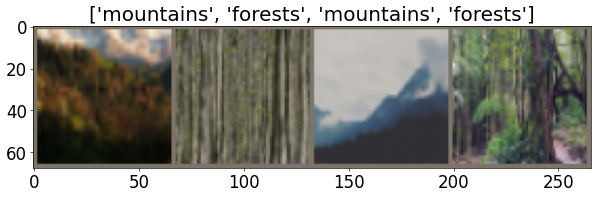

In [13]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# 화면에 출력되는 이미지 크기를 적절하게 조절하기
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(image, title):
    #tensor -> numpy
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()

#학습 데이터셋에서 하나의 배치 불러오기
iterator = iter(train_dataloader)
 #현재 배치에 포함된 이미지 출력
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

+ conv 연산의 이해

height = 16
width =16
filter h= 4
fitler w =4
stride =2
padding=1

In [15]:
height = 16
width = 16
filter_height = 4
filter_width = 4
stride = 2
padding = 1

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)

출력 높이: 8 출력 너비: 8


LeNet

In [16]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (20 x 60 x 60)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (20 x 30 x 30)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1, padding=0)
        # → 차원(dimension): (50 x 26 x 26)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (50 x 13 x 13)
        self.fc1 = nn.Linear(50 * 13 * 13, 500)
        # → 차원(dimension): (500)
        self.fc2 = nn.Linear(500, 6)
        # → 차원(dimension): (6)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = torch.flatten(x, 1) # 배치(batch)를 제외한 모든 차원 flatten하기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
def train(net, epoch, optimizer, criterion, train_dataloader):
    print('[ Train epoch: %d ]' % epoch)
    net.train() # 모델을 학습 모드로 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad() # 기울기(gradient) 초기화

        outputs = net(inputs) # 모델 입력하여 결과 계산
        loss = criterion(outputs, targets) # 손실(loss) 값 계산
        loss.backward() # 역전파를 통해 기울기(gradient) 계산

        optimizer.step() # 계산된 기울기를 이용해 모델 가중치 업데이트
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Train accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)
    return (100. * correct / total, train_loss / total)


def validate(net, epoch, val_dataloader):
    print('[ Validation epoch: %d ]' % epoch)
    net.eval() # 모델을 평가 모드로 설정
    val_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(val_dataloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs) # 모델 입력하여 결과 계산
        val_loss += criterion(outputs, targets).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Accuarcy:', 100. * correct / total)
    print('Average loss:', val_loss / total)
    return (100. * correct / total, val_loss / total)

앞서 정의한 LeNet 을 학습해보자

In [18]:
import time
import torch.optim as optim


net = LeNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "LeNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 50.54670874000147
Train average loss: 0.03952065253892858
[ Validation epoch: 1 ]
Accuarcy: 66.36336953331377
Average loss: 0.029980902084689846
Model saved! (time elapsed: 72.02280282974243)
[ Train epoch: 1 ]
Train accuarcy: 57.510824099214794
Train average loss: 0.034154526042406354
[ Validation epoch: 2 ]
Accuarcy: 65.80569415908424
Average loss: 0.027669333575371602
Model saved! (time elapsed: 142.90193510055542)
[ Train epoch: 2 ]
Train accuarcy: 60.5635869964042
Train average loss: 0.03221639138530581
[ Validation epoch: 3 ]
Accuarcy: 70.76606985617846
Average loss: 0.026013094884823732
Model saved! (time elapsed: 212.82620406150818)
[ Train epoch: 3 ]
Train accuarcy: 62.743083584061054
Train average loss: 0.030467961756894566
[ Validation epoch: 4 ]
Accuarcy: 71.1476372174934
Average loss: 0.024772951609583798
Model saved! (time elapsed: 282.80656337738037)
[ Train epoch: 4 ]
Train accuarcy: 64.37220224554194
Train average loss: 0.029511644763

정확도, 손실 커브 시각화

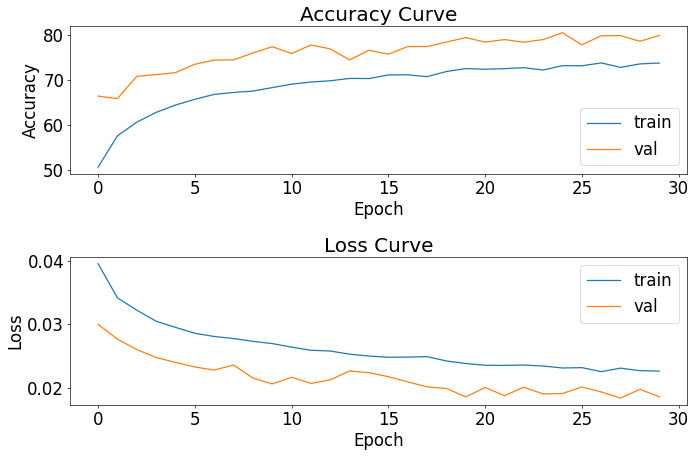

In [19]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

각 클래스에 대해 정확히 분류하는지 확인하기 위해 혼동행력 시각화


In [20]:
# 네트워크에 데이터셋을 입력하여 혼동 행렬(confusion matrix)을 계산하는 함수
def get_confusion_matrix(net, num_classes, data_loader):
    net.eval() # 모델을 평가 모드로 설정
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        _, predicted = outputs.max(1)

        for t, p in zip(targets.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    return confusion_matrix

[ 각 클래스당 데이터 개수 ]
tensor([523, 540, 594, 599, 560, 591])
[ 혼동 행렬(confusion matrix) 시각화 ]


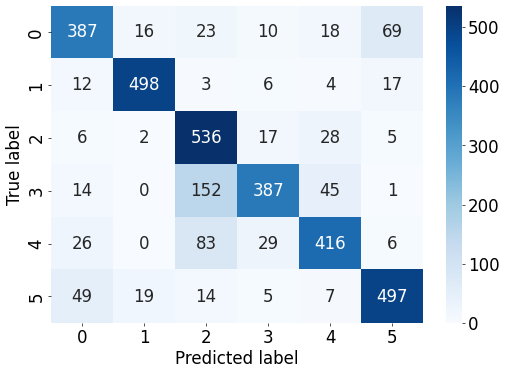

[ 각 클래스에 따른 정확도 ]
tensor([0.7400, 0.9222, 0.9024, 0.6461, 0.7429, 0.8409])
[ 전체 평균 정확도 ]
tensor(0.7986)


In [21]:
import pandas as pd
import seaborn as sns


net = LeNet()
net = net.to(device)

file_name = "./checkpoint/LeNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

CustomLeNet

In [24]:
height = 64
width = 64
filter_height = 8
filter_width = 8
stride = 1
padding = 0

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)

출력 높이: 57 출력 너비: 57


In [28]:
height = 28
width = 28
filter_height = 8
filter_width = 8
stride = 1
padding =0

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)

출력 높이: 21 출력 너비: 21


In [30]:
height = 10
width = 10
filter_height = 4
filter_width = 4
stride = 1
padding = 0

output_height = (height + 2 * padding - filter_height) // stride + 1
output_width = (width + 2 * padding - filter_width) // stride + 1

print('출력 높이:', output_height, '출력 너비:', output_width)

출력 높이: 7 출력 너비: 7


In [32]:
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        # → 차원(dimension): (3 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=8, stride=1, padding=0)
        # → 차원(dimension): (128 x 57 x 57)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (128 x 28 x 28)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=8, stride=1, padding=0)
        # → 차원(dimension): (256 x 21 x 21)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (256 x 10 x 10)
        
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=1, padding=0)
        # → 차원(dimension): (512 x 7 x 7)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # → 차원(dimension): (512 x 3 x 3)
        
        self.fc1 = nn.Linear(512 * 3 * 3, 4096)
        # → 차원(dimension): (4096)
        self.fc2 = nn.Linear(4096, 6)
        # → 차원(dimension): (6)

    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x = self.pool3(self.conv3(x))
        x = torch.flatten(x, 1) # 배치(batch)를 제외한 모든 차원 flatten하기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import time
import torch.optim as optim


net = CustomLeNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "CustomLeNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

[ Train epoch: 0 ]
Train accuarcy: 47.77280399207456
Train average loss: 0.041029574372076084
[ Validation epoch: 1 ]
Accuarcy: 59.37775168770179
Average loss: 0.034108659582191246
Model saved! (time elapsed: 1441.75332570076)
[ Train epoch: 1 ]
Train accuarcy: 55.889043810082924
Train average loss: 0.03538479951609517
[ Validation epoch: 2 ]
Accuarcy: 62.6063985911359
Average loss: 0.031380942867129016
Model saved! (time elapsed: 2874.450889110565)
[ Train epoch: 2 ]
Train accuarcy: 58.78036251559404
Train average loss: 0.03361758412378431
[ Validation epoch: 3 ]
Accuarcy: 67.30261226885823
Average loss: 0.028748934836481405
Model saved! (time elapsed: 4306.386755228043)
[ Train epoch: 3 ]


In [ ]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns


net = CustomLeNet()
net = net.to(device)

file_name = "./checkpoint/CustomLeNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())

AlexNet

In [ ]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        #특징추출
        self.features = nn.Sequential(
            #Conv1
            #input channel : 3 (rgb 3채널) , output channel : 64, kernel_size : 11, stride : 4, padding : 2
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True), # inplace=True 하면, inplace 연산을 수행함(교체), inplace 연산은 결과값을 새로운 변수에 값을 저장하는 대신 기존의 데이터를 대체하는것을 의미
            #Max Pool1
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Conv2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            #Max Pool2
            nn.MaxPool2d(kernel_size=3, stride=2),
            #Conv3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            ##Conv4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Conv5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #Max Pool3
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        #분류
        #시퀀셜 형태로 layer을 쌓을거임
        self.classifier = nn.Sequential(
            #드롭아웃 
            nn.Dropout(), 
            nn.Linear(256 * 6 * 6, 4096), #fully connected layer를 linear로 쌓음
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes), #최종 분류 층, 사용하려는 전체 클래스 개수와 맞춰줌(output num_class)
        )
        
        #이미지가 들어왔을때 어떤 순서를 거쳐 진행되는지 forward함수로 지정해줌
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #특징 추출 부분
        x = self.features(x)
       
        x = self.avgpool(x)
        #output shape : (batch size * 256(channel), 6, 6)
        #Flatten
        x = torch.flatten(x, 1) #한 배치마다 특징을 펼쳐서
        #output shape (batch_size, 256 * 6* 6)
        #분류 
        x = self.classifier(x) #분류
        
        return x

In [ ]:
import time
import torch.optim as optim


net = AlexNet()
net = net.to(device)

epoch = 30
learning_rate = 0.002
file_name = "AlexNet.pt"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

train_result = []
val_result = []

start_time = time.time() # 시작 시간

for i in range(epoch):
    train_acc, train_loss = train(net, i, optimizer, criterion, train_dataloader) # 학습(training)
    val_acc, val_loss = validate(net, i + 1, val_dataloader) # 검증(validation)

    # 학습된 모델 저장하기
    state = {
        'net': net.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print(f'Model saved! (time elapsed: {time.time() - start_time})')

    # 현재 epoch에서의 정확도(accuracy)와 손실(loss) 값 저장하기
    train_result.append((train_acc, train_loss))
    val_result.append((val_acc, val_loss))

In [ ]:
# 정확도(accuracy) 커브 시각화
plt.subplot(211)
plt.plot([i for i in range(epoch)], [i[0] for i in train_result])
plt.plot([i for i in range(epoch)], [i[0] for i in val_result])
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])

# 손실(loss) 커브 시각화
plt.subplot(212)
plt.plot([i for i in range(epoch)], [i[1] for i in train_result])
plt.plot([i for i in range(epoch)], [i[1] for i in val_result])
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "val"])

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns


net = AlexNet()
net = net.to(device)

file_name = "./checkpoint/AlexNet.pt"
checkpoint = torch.load(file_name)
net.load_state_dict(checkpoint['net'])

# 평가 데이터셋을 이용해 혼동 행렬(confusion matrix) 계산하기
confusion_matrix = get_confusion_matrix(net, 6, val_dataloader)
print("[ 각 클래스당 데이터 개수 ]")
print(confusion_matrix.sum(1))

print("[ 혼동 행렬(confusion matrix) 시각화 ]")
res = pd.DataFrame(confusion_matrix.numpy(), index = [i for i in range(6)], columns = [i for i in range(6)])
res.index.name = 'True label'
res.columns.name = 'Predicted label'
plt.figure(figsize = (10, 7))
sns.heatmap(res, annot=True, fmt="d", cmap='Blues')
plt.show()

print("[ 각 클래스에 따른 정확도 ]")
# (각 클래스마다 정답 개수 / 각 클래스마다 데이터의 개수)
print(confusion_matrix.diag() / confusion_matrix.sum(1))

print("[ 전체 평균 정확도 ]")
print(confusion_matrix.diag().sum() / confusion_matrix.sum())